In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage.registration import optical_flow_tvl1
from skimage.transform import warp
from skimage.color import rgb2gray
from scipy.ndimage import shift
from skimage.filters import gaussian, median
from FFT_blur_detection import *
import cv2

debug_mode=False

In [2]:
def align_image(img1_color, img2_color):
    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
    height, width = img2.shape
 
    orb_detector = cv2.ORB_create(5000)

    kp1, d1 = orb_detector.detectAndCompute(img1, None)
    kp2, d2 = orb_detector.detectAndCompute(img2, None)
 
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
 
    matches = matcher.match(d1, d2)
 
    matches.sort(key = lambda x: x.distance)
 
    matches = matches[:int(len(matches)*0.9)]
    no_of_matches = len(matches)
 
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))
 
    for i in range(len(matches)):
      p1[i, :] = kp1[matches[i].queryIdx].pt
      p2[i, :] = kp2[matches[i].trainIdx].pt
 
    homography, mask = cv2.findHomography(p2, p1, cv2.RANSAC)
 
    transformed_img = cv2.warpPerspective(img2_color,
                    homography, (width, height))
    return transformed_img

In [3]:
fp=np.ones((3,3,1))
base_img=median(plt.imread('fly_blur_1.jpg'),fp)

all_images=[]
all_images_unaltered=[]
for filename in glob.glob('fly*'):
    all_images_unaltered.append(plt.imread(filename))
    all_images.append(median(plt.imread(filename),fp))

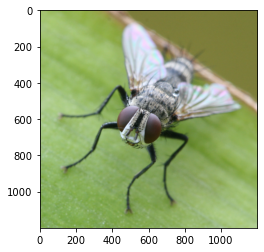

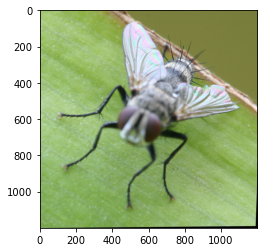

In [4]:
registered_images=[]
for image in all_images:
    corrected_img=align_image(base_img,image)
    plt.imshow(corrected_img)
    plt.show()
    registered_images.append(corrected_img)

In [5]:
#Create a mask for each image

num_images=len(all_images)
img_width=base_img.shape[0]
img_height=base_img.shape[1]
window_size=max(10,img_width*img_height//150000)
print(base_img.shape)

blur_scores=np.zeros((num_images))
masks=np.zeros((num_images, img_width,img_height))


for window_x in range(0,img_width,window_size):
    if window_x+window_size>img_width:
        break
    for window_y in range(0,img_height,window_size):
        if window_y+window_size>img_height:
            break
        for i,image in enumerate(registered_images):
            blur_scores[i]=blur_detect(image[window_x:window_x+window_size,window_y:window_y+window_size])
        least_blurry=blur_scores.argmax()
        masks[least_blurry,window_x:window_x+window_size,window_y:window_y+window_size]=1

(1200, 1200, 3)


In [6]:
#Blur masks and then normalize so they add up to 1 at each pixel

for i in range(num_images):
    masks[i,:,:]=gaussian(masks[i,:,:],sigma=window_size//2)

for x in range(img_width):
    for y in range(img_height):
        for i in range(num_images):
            if sum(masks[:,x,y])==0:
                masks[i,x,y]=0
            else:
                masks[i,x,y]= masks[i,x,y]/sum(masks[:,x,y])

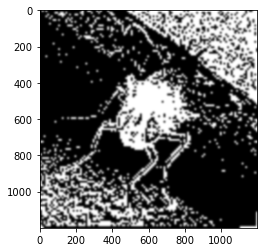

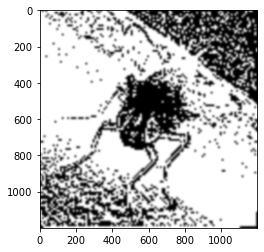

In [7]:
for i in range(num_images):
    plt.imshow(masks[i,:,:],cmap='gray')
    plt.show()

In [8]:
#reconstruct image from masks

stacked_img=np.zeros_like(base_img).astype('float64')
for i, image in enumerate(registered_images):
    stacked_img[:,:,0]+=np.multiply(masks[i,:,:],image[:,:,0]) #red channel
    stacked_img[:,:,1]+=np.multiply(masks[i,:,:],image[:,:,1]) #green channel
    stacked_img[:,:,2]+=np.multiply(masks[i,:,:],image[:,:,2]) #blue channel

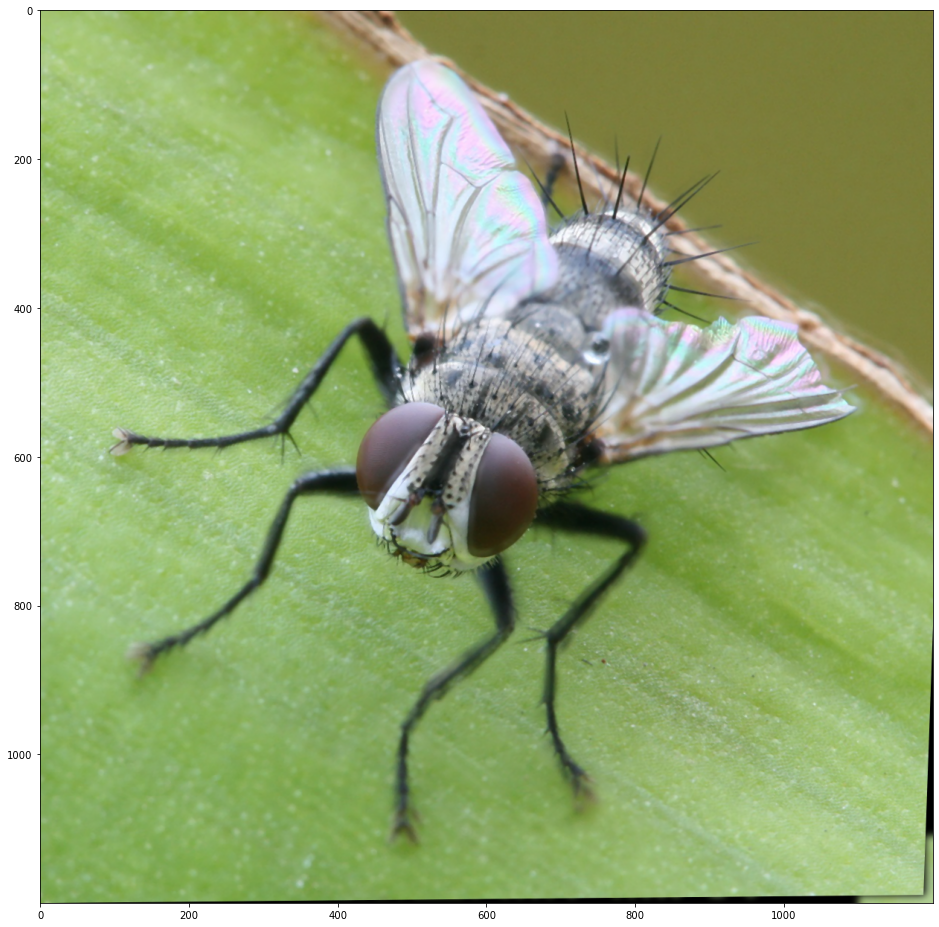

In [9]:
stacked_img=stacked_img.astype('uint8')
plt.figure(figsize=(16,24))
plt.imshow(stacked_img)